# 観光入込客数の分析

In [150]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

## 1. sheet1, 2, 4, 5の加工用関数の定義

In [151]:
h26_files = ["data/H26-{0}.xlsx".format(i) for i in range(1, 5)]
h27_files = ["data/H27-{0}.xlsx".format(i) for i in range(1, 5)]
h28_files = ["data/H28-{0}.xlsx".format(i) for i in range(1, 5)]
h29_files = ["data/H29-{0}.xlsx".format(i) for i in range(1, 5)]

In [161]:
def process_files1(files):
    '''sheet1と2の加工'''

    col_names = ["都道府県", "①_県内_宿泊", "①_県内_日帰り", "①_県外_宿泊", "①_県外_日帰り",
    "②_県内_宿泊", "②_県内_日帰り", "②_県外_宿泊", "②_県外_日帰り"]

    sheet1 = pd.DataFrame()

    for(i, file) in enumerate(files):
        temp = pd.read_excel(file, sheet_name=1, skiprows=6, skipfooter=1, usecols=range(9),
                             names=col_names, index_col=0, na_values=["集計中", "-"])
        temp = temp.stack()
        temp.index.rename("客層", level=1, inplace=True)
        temp.name = f"{i + 1}_観光"
        temp = temp.reset_index()
        if not sheet1.empty: sheet1 = pd.merge(sheet1, temp, on=["都道府県", "客層"], how="left")
        else: sheet1 = temp

    sheet2 = pd.DataFrame()

    for(i, file) in enumerate(files):
        temp = pd.read_excel(file, sheet_name=2, skiprows=6, skipfooter=1, usecols=range(9),
                             names=col_names, index_col=0, na_values=["集計中", "-"])
        temp = temp.stack()
        temp.index.rename("客層", level=1, inplace=True)
        temp.name = f"{i + 1}_ビジネス"
        temp = temp.reset_index()
        if not sheet2.empty: sheet2 = pd.merge(sheet2, temp, on=["都道府県", "客層"], how="left")
        else: sheet2 = temp

    df = pd.DataFrame()
    df = pd.merge(sheet1, sheet2, on=["都道府県", "客層"], how="left")
    df = df.dropna(how="any")
    df.insert(1, "種類", "①")
    df["種類"].where(df["客層"].str.contains("①"), "②", inplace=True)
    df.drop(columns="客層", inplace=True)
    df = df.groupby(["都道府県", "種類"], as_index=False).sum()
    df.iloc[:, 2:] = df.iloc[:, 2:].astype(int)

    return df

def process_files2(files):
    '''sheet4と5の加工'''

    col_names = ["都道府県", "自然", "歴史・文化", "温泉・健康", "スポーツ・レク", "都市型観光", "イベント"]

    sheet4 = pd.DataFrame()
    use_cols_4 = [0, 3, 4, 5, 6, 7, 10]

    for(i, file) in enumerate(files):
        temp = pd.read_excel(file, sheet_name=4, skiprows=6, skipfooter=1, usecols=use_cols_4, names=col_names, index_col=0)
        temp = temp.stack()
        temp.index.rename("目的", level=1, inplace=True)
        temp.name = "地点数"
        temp = temp.reset_index()
        if not sheet4.empty: sheet4 = pd.concat([sheet4, temp], ignore_index=True)
        else: sheet4 = temp

    sheet5 = pd.DataFrame()
    use_cols_5 = [0, 3, 4, 5, 6, 7, 9]

    for(i, file) in enumerate(files):
        temp = pd.read_excel(file, sheet_name=5, skiprows=6, skipfooter=1, usecols=use_cols_5, names=col_names, index_col=0)
        temp = temp.stack()
        temp.index.rename("目的", level=1, inplace=True)
        temp.name = "客数"
        temp = temp.reset_index()
        if not sheet5.empty: sheet5 = pd.concat([sheet5, temp], ignore_index=True)
        else: sheet5 = temp

    df = pd.DataFrame()
    df = pd.merge(sheet4, sheet5, left_index=True, right_index=True, on=["都道府県", "目的"], how="left")
    df = df.dropna(how="any")
    df["都道府県"] = df["都道府県"].str[3:]

    return df

## 2. sheet1, 2, 4, 5の加工

In [162]:
# sheet1&sheet2
h26_jp = process_files1(h26_files)
h27_jp = process_files1(h27_files)
h28_jp = process_files1(h28_files)
h29_jp = process_files1(h29_files)
h26_jp.to_csv("data_after/jp/h26.csv", index=False)
h27_jp.to_csv("data_after/jp/h27.csv", index=False)
h28_jp.to_csv("data_after/jp/h28.csv", index=False)
h29_jp.to_csv("data_after/jp/h29.csv", index=False)

#sheet4&sheet5
h26_resorts = process_files2(h26_files)
h27_resorts = process_files2(h27_files)
h28_resorts = process_files2(h28_files)
h29_resorts = process_files2(h29_files)
resorts = pd.concat([h26_resorts, h27_resorts, h28_resorts, h29_resorts], ignore_index=True)
resorts.to_csv("data_after/resorts/resorts.csv", index=False)

## 3. クラスタリング

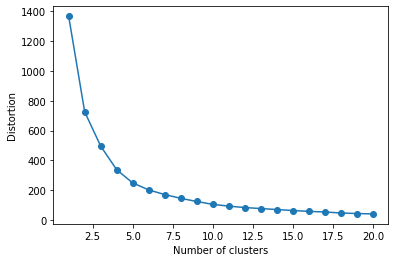

In [155]:
purpose = resorts[resorts.目的=="自然"].iloc[:, [2, 3]] #目的を設定

sc = StandardScaler()
purpose_sc = sc.fit_transform(purpose)

#エルボー法により適切なクラスタ数を調べる
distortions = []
for i  in range(1,21):
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(purpose_sc)
    distortions.append(km.inertia_)

plt.plot(range(1,21),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [156]:
#k-meansでクラスタリング
km = KMeans(n_clusters=5, random_state=0)
clusters = km.fit(purpose_sc)
purpose["cluster"] = clusters.labels_
purpose = pd.merge(purpose, resorts["都道府県"], left_index=True, right_index=True, how="left")
purpose = purpose.iloc[:, [3, 0, 1, 2]]
purpose.reset_index(drop=True, inplace=True)

In [157]:
#岩手県がどのクラスタに分類されたのかを確認
iwate = purpose.loc[purpose["都道府県"] == "岩手県"]
iwate

,都道府県,地点数,客数,cluster
2,岩手県,33.0,604.000,1
47,岩手県,33.0,1226.000,1
91,岩手県,34.0,1706.000,0
135,岩手県,34.0,914.000,1
179,岩手県,34.0,911.000,1
223,岩手県,35.0,1406.000,1
266,岩手県,35.0,1922.000,0
309,岩手県,36.0,969.000,1
352,岩手県,37.0,454.000,1
395,岩手県,37.0,1204.000,1


In [158]:
#クラスタごとのデータ数を確認
purpose.groupby("cluster").count()

,都道府県,地点数,客数
cluster,,,
0,90,90,90
1,244,244,244
2,24,24,24
3,53,53,53
4,272,272,272


In [159]:
#クラスタごとの地点数と客数の平均値を算出
purpose_mean = purpose.groupby("cluster").mean()

#1地点あたりの客数の列を追加
purpose_mean["1地点あたりの客数"] = purpose_mean["客数"] / purpose_mean["地点数"]
purpose_mean.sort_values("1地点あたりの客数", ascending=False, inplace=True)
purpose_mean

,地点数,客数,1地点あたりの客数
cluster,,,
2,58.958333,6340.037841,107.534211
0,40.577778,2375.365643,58.538584
4,16.889706,473.817908,28.053651
1,36.553279,789.154995,21.589171
3,80.867925,1514.956043,18.733707
